In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
import pandas as pd;

2.3.0


In [2]:
multi_data = pd.read_csv('./../data/zri_multifamily_v2.csv')

In [3]:
multi_data

,zip,City,State,Metro,CountyName,year-month,zri
0,1013,Chicopee,MA,Springfield,Hampden County,2014-01,928.0
1,1013,Chicopee,MA,Springfield,Hampden County,2014-02,931.0
2,1013,Chicopee,MA,Springfield,Hampden County,2014-03,934.0
3,1013,Chicopee,MA,Springfield,Hampden County,2014-04,929.0
4,1013,Chicopee,MA,Springfield,Hampden County,2014-05,929.0
...,...,...,...,...,...,...,...
93739,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-08,1277.0
93740,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-09,1271.0
93741,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-10,1299.0
93742,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-11,1261.5


In [4]:
multi_data["zip"].unique()[300]

11225

In [5]:
tf.random.set_seed(0)

In [6]:
ZONE = 10128;
SPLIT = 60; # 2014-2018: training, 2019: testing.
BATCH_SIZE = 10;
WINDOW_SIZE = 3;

In [7]:
single_city_data = multi_data[multi_data["zip"] == ZONE];

single_city_series = np.array(single_city_data["zri"])

In [8]:
single_city_series_mean = single_city_series.mean();
single_city_series_std = single_city_series.std();
print(single_city_series_std)

single_city_series = (single_city_series - single_city_series_mean)/single_city_series_std;

215.81157018387935


In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

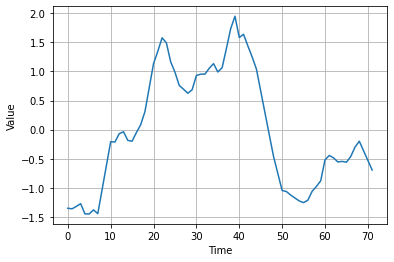

In [10]:
plot_series(list(range(len(single_city_series))), single_city_series)

In [11]:
# single_city_series = np.log10(single_city_series);

In [12]:
single_city_train = single_city_series[:SPLIT];
single_city_test = single_city_series[SPLIT:];

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [14]:
dataset = windowed_dataset(single_city_train, WINDOW_SIZE, BATCH_SIZE, 60)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [15]:
for x, y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
# batch size tells how many windows per batch
# we have batches of 5 windows of size 12
# this gives 9 full batches

x =  [[ 1.49181709  1.16746006  0.98674686]
 [-1.06596978 -1.12620751 -1.1771779 ]
 [-1.21424728 -1.0613361  -0.97793001]
 [-1.25595032 -1.21424728 -1.0613361 ]
 [ 1.05625194  1.13502436  0.99138053]
 [-0.21337415 -0.06973033 -0.03729462]
 [-1.04743509 -1.06596978 -1.12620751]
 [-0.46359243 -0.75551376 -1.04743509]
 [-1.22814829 -1.25595032 -1.21424728]
 [ 1.64009459  1.4408467   1.25086615]]
y =  [ 0.75969694 -1.22814829 -0.8806229  -0.97793001  1.06551928 -0.18557212
 -1.1771779  -1.06596978 -1.0613361   1.04235092]
x =  [[-0.62113728 -0.20874048 -0.21337415]
 [ 1.04235092  0.66470666  0.28706241]
 [ 1.7374017   1.95055061  1.58449053]
 [-1.36252478 -1.32082173 -1.27448501]
 [ 1.34817326  1.57985686  1.49181709]
 [ 1.4408467   1.25086615  1.04235092]
 [-0.75551376 -1.04743509 -1.06596978]
 [ 0.9311428   0.95431116  0.95431116]
 [-0.20874048 -0.21337415 -0.06973033]
 [-1.27448501 -1.45056454 -1.45056454]]
y =  [-0.06973033 -0.08826501  1.64009459 -1.45056454  1.16746006  0.66470666
 -

In [16]:
tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                  input_shape=[None]),
#   tf.keras.layers.Conv1D(filters=16, kernel_size=3,
#                       strides=1, padding="causal",
#                       activation="relu",
#                       input_shape=[None, 1]),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.mae,
              optimizer="adam",
              metrics=["mae", "mse"])
history = model.fit(dataset, epochs=500)

Epoch 1/500
6/6 [==============================] - 0s 6ms/step - loss: 1.0706 - mae: 1.0706 - mse: 1.4379
Epoch 2/500
6/6 [==============================] - 0s 2ms/step - loss: 1.0543 - mae: 1.0543 - mse: 1.3955
Epoch 3/500
6/6 [==============================] - 0s 2ms/step - loss: 1.0398 - mae: 1.0398 - mse: 1.3585
Epoch 4/500
6/6 [==============================] - 0s 3ms/step - loss: 1.0237 - mae: 1.0237 - mse: 1.3173
Epoch 5/500
6/6 [==============================] - 0s 3ms/step - loss: 1.0090 - mae: 1.0090 - mse: 1.2796
Epoch 6/500
6/6 [==============================] - 0s 2ms/step - loss: 0.9942 - mae: 0.9942 - mse: 1.2423
Epoch 7/500
6/6 [==============================] - 0s 2ms/step - loss: 0.9788 - mae: 0.9788 - mse: 1.2062
Epoch 8/500
6/6 [==============================] - 0s 3ms/step - loss: 0.9630 - mae: 0.9630 - mse: 1.1690
Epoch 9/500
6/6 [==============================] - 0s 2ms/step - loss: 0.9482 - mae: 0.9482 - mse: 1.1331
Epoch 10/500
6/6 [============================

6/6 [==============================] - 0s 3ms/step - loss: 0.4187 - mae: 0.4187 - mse: 0.2784
Epoch 78/500
6/6 [==============================] - 0s 3ms/step - loss: 0.4165 - mae: 0.4165 - mse: 0.2760
Epoch 79/500
6/6 [==============================] - 0s 2ms/step - loss: 0.4142 - mae: 0.4142 - mse: 0.2734
Epoch 80/500
6/6 [==============================] - 0s 3ms/step - loss: 0.4121 - mae: 0.4121 - mse: 0.2712
Epoch 81/500
6/6 [==============================] - 0s 3ms/step - loss: 0.4098 - mae: 0.4098 - mse: 0.2686
Epoch 82/500
6/6 [==============================] - 0s 2ms/step - loss: 0.4076 - mae: 0.4076 - mse: 0.2663
Epoch 83/500
6/6 [==============================] - 0s 2ms/step - loss: 0.4053 - mae: 0.4053 - mse: 0.2638
Epoch 84/500
6/6 [==============================] - ETA: 0s - loss: 0.3788 - mae: 0.3788 - mse: 0.228 - 0s 2ms/step - loss: 0.4032 - mae: 0.4032 - mse: 0.2614
Epoch 85/500
6/6 [==============================] - 0s 3ms/step - loss: 0.4009 - mae: 0.4009 - mse: 0.259

6/6 [==============================] - 0s 2ms/step - loss: 0.2944 - mae: 0.2944 - mse: 0.1596
Epoch 153/500
6/6 [==============================] - 0s 3ms/step - loss: 0.2938 - mae: 0.2938 - mse: 0.1589
Epoch 154/500
6/6 [==============================] - 0s 1ms/step - loss: 0.2927 - mae: 0.2927 - mse: 0.1584
Epoch 155/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2922 - mae: 0.2922 - mse: 0.1581
Epoch 156/500
6/6 [==============================] - 0s 1ms/step - loss: 0.2920 - mae: 0.2920 - mse: 0.1579
Epoch 157/500
6/6 [==============================] - 0s 1ms/step - loss: 0.2910 - mae: 0.2910 - mse: 0.1576
Epoch 158/500
6/6 [==============================] - 0s 1ms/step - loss: 0.2905 - mae: 0.2905 - mse: 0.1573
Epoch 159/500
6/6 [==============================] - 0s 1ms/step - loss: 0.2902 - mae: 0.2902 - mse: 0.1572
Epoch 160/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2895 - mae: 0.2895 - mse: 0.1566
Epoch 161/500
6/6 [=======================

Epoch 228/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2704 - mae: 0.2704 - mse: 0.1445
Epoch 229/500
6/6 [==============================] - 0s 3ms/step - loss: 0.2704 - mae: 0.2704 - mse: 0.1445
Epoch 230/500
6/6 [==============================] - 0s 3ms/step - loss: 0.2700 - mae: 0.2700 - mse: 0.1442
Epoch 231/500
6/6 [==============================] - 0s 1ms/step - loss: 0.2698 - mae: 0.2698 - mse: 0.1441
Epoch 232/500
6/6 [==============================] - 0s 1ms/step - loss: 0.2697 - mae: 0.2697 - mse: 0.1441
Epoch 233/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2695 - mae: 0.2695 - mse: 0.1438
Epoch 234/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2700 - mae: 0.2700 - mse: 0.1437
Epoch 235/500
6/6 [==============================] - 0s 1ms/step - loss: 0.2694 - mae: 0.2694 - mse: 0.1435
Epoch 236/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2693 - mae: 0.2693 - mse: 0.1437
Epoch 237/500
6/6 [=========

6/6 [==============================] - 0s 2ms/step - loss: 0.2630 - mae: 0.2630 - mse: 0.1424
Epoch 303/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2633 - mae: 0.2633 - mse: 0.1424
Epoch 304/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2631 - mae: 0.2631 - mse: 0.1426
Epoch 305/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2630 - mae: 0.2630 - mse: 0.1425
Epoch 306/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2633 - mae: 0.2633 - mse: 0.1426
Epoch 307/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2629 - mae: 0.2629 - mse: 0.1424
Epoch 308/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2632 - mae: 0.2632 - mse: 0.1426
Epoch 309/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2630 - mae: 0.2630 - mse: 0.1426
Epoch 310/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2629 - mae: 0.2629 - mse: 0.1424
Epoch 311/500
6/6 [=======================

6/6 [==============================] - 0s 2ms/step - loss: 0.2594 - mae: 0.2594 - mse: 0.1407
Epoch 378/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2598 - mae: 0.2598 - mse: 0.1408
Epoch 379/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2595 - mae: 0.2595 - mse: 0.1408
Epoch 380/500
6/6 [==============================] - 0s 3ms/step - loss: 0.2595 - mae: 0.2595 - mse: 0.1408
Epoch 381/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2593 - mae: 0.2593 - mse: 0.1407
Epoch 382/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2592 - mae: 0.2592 - mse: 0.1406
Epoch 383/500
6/6 [==============================] - 0s 1ms/step - loss: 0.2593 - mae: 0.2593 - mse: 0.1406
Epoch 384/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2593 - mae: 0.2593 - mse: 0.1405
Epoch 385/500
6/6 [==============================] - 0s 1ms/step - loss: 0.2588 - mae: 0.2588 - mse: 0.1404
Epoch 386/500
6/6 [=======================

Epoch 453/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2545 - mae: 0.2545 - mse: 0.1388
Epoch 454/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2545 - mae: 0.2545 - mse: 0.1388
Epoch 455/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2545 - mae: 0.2545 - mse: 0.1387
Epoch 456/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2542 - mae: 0.2542 - mse: 0.1387
Epoch 457/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2541 - mae: 0.2541 - mse: 0.1388
Epoch 458/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2544 - mae: 0.2544 - mse: 0.1391
Epoch 459/500
6/6 [==============================] - 0s 1ms/step - loss: 0.2540 - mae: 0.2540 - mse: 0.1388
Epoch 460/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2543 - mae: 0.2543 - mse: 0.1388
Epoch 461/500
6/6 [==============================] - 0s 2ms/step - loss: 0.2540 - mae: 0.2540 - mse: 0.1386
Epoch 462/500
6/6 [=========

In [17]:
time_train = list(range(SPLIT));
time_test = list(range(SPLIT, len(single_city_series)))

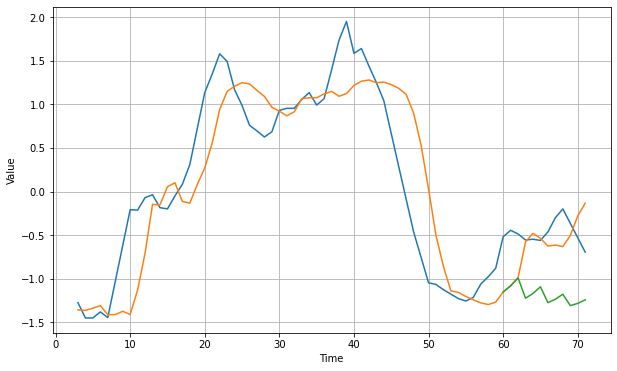

In [18]:
forecast = []
results = []
for time in range(len(single_city_series) - WINDOW_SIZE):
    forecast.append(model.predict(single_city_series[time:time + WINDOW_SIZE][np.newaxis]))

#print(forecast)

# forecast = forecast[SPLIT - WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]
actual = single_city_series[WINDOW_SIZE:]
time_actual = range(WINDOW_SIZE, len(single_city_series));

pure_forecast = list(single_city_series[SPLIT - WINDOW_SIZE: SPLIT]);
for time in range(SPLIT, len(single_city_series)):
    pure_forecast.append(np.array(model.predict(np.array(pure_forecast[-WINDOW_SIZE:])[np.newaxis]))[0][0][0])
pure_forecast = np.array(pure_forecast[WINDOW_SIZE:]);


plt.figure(figsize=(10, 6))

plot_series(time_actual, actual);
plot_series(time_actual, results);
plot_series(time_test, pure_forecast);

In [19]:
pure_forecast

array([-1.1526934, -1.0814954, -0.9906459, -1.2239289, -1.1690068,
       -1.0927417, -1.274833 , -1.2359362, -1.1779594, -1.3088473,
       -1.2830297, -1.2424363], dtype=float32)

In [20]:
single_city_test

array([-0.5191965 , -0.44505775, -0.48676079, -0.55626587, -0.54699853,
       -0.56089954, -0.46359243, -0.30141392, -0.19947314, -0.36474077,
       -0.5300084 , -0.69527603])

In [21]:
inv_forecast = pure_forecast*single_city_series_std+single_city_series_mean

In [22]:
inv_test = single_city_test*single_city_series_std+single_city_series_mean

In [23]:
np.sqrt(sum((inv_forecast-inv_test)**2)/12)

157.88251527132277

In [24]:
# 93.6 w/ window size 12
# 113.53885532608837 w/ window 3
# 163.8636742139567 w/ 12